1. Import Necessary Libraries

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms


2. Define Utility Functions for Loading and Preprocessing Data

In [52]:
def load_and_preprocess_image(image_path, img_size=(32, 32)):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize the pixels to [0,1]
        img = tf.image.resize(img, img_size)
        return img
    except tf.errors.NotFoundError:
        raise ValueError(f"Image not found or unable to load: {image_path}")

def load_dataset(dataset_path, csv_file, img_size=(32, 32)):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in df.iterrows():
        image_path = os.path.join(dataset_path, row['Path'])
        images.append(load_and_preprocess_image(image_path, img_size))
        labels.append(row['ClassId'])
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

# Update these paths according to your dataset location
TRAIN_PATH = r"C:\Users\youse\Desktop\FDS final"  # Update this
TEST_PATH = r"C:\Users\youse\Desktop\FDS final"    # Update this
TRAIN_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"
TEST_CSV = r"C:\Users\youse\Desktop\FDS final\Test.csv"

train_images, train_labels = load_dataset(TRAIN_PATH, TRAIN_CSV)
test_images, test_labels = load_dataset(TEST_PATH, TEST_CSV)

# Split the training data for validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images.numpy(), train_labels.numpy(), test_size=0.2, random_state=42)

3. Load and Split the Dataset

4. Build the CNN Model

In [53]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


5. Train the Model

Epoch 1/10
316/316 [==============================] - 4s 9ms/step - loss: 2.2222 - accuracy: 0.4048 - val_loss: 0.9453 - val_accuracy: 0.7518
Epoch 2/10
316/316 [==============================] - 3s 9ms/step - loss: 0.5752 - accuracy: 0.8369 - val_loss: 0.3571 - val_accuracy: 0.9066
Epoch 3/10
316/316 [==============================] - 3s 8ms/step - loss: 0.2458 - accuracy: 0.9322 - val_loss: 0.2195 - val_accuracy: 0.9414
Epoch 4/10
316/316 [==============================] - 3s 8ms/step - loss: 0.1529 - accuracy: 0.9611 - val_loss: 0.1469 - val_accuracy: 0.9624
Epoch 5/10
316/316 [==============================] - 3s 8ms/step - loss: 0.1036 - accuracy: 0.9719 - val_loss: 0.1231 - val_accuracy: 0.9667
Epoch 6/10
316/316 [==============================] - 3s 8ms/step - loss: 0.0788 - accuracy: 0.9776 - val_loss: 0.1309 - val_accuracy: 0.9620
Epoch 7/10
316/316 [==============================] - 3s 8ms/step - loss: 0.0570 - accuracy: 0.9841 - val_loss: 0.1083 - val_accuracy: 0.9711
Epoch 

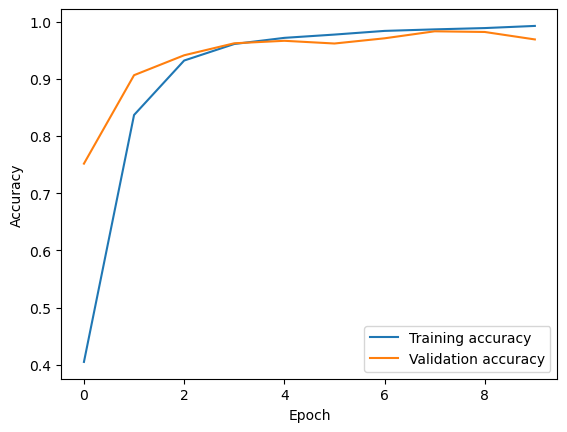

In [54]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


6. Create Adversarial Examples Using FGSM

In [67]:
def create_adversarial_pattern(input_image, input_label, model):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

# Select a subset for adversarial attack demonstration
test_subset = test_images[:100]
test_labels_subset = test_labels[:100]

# Create adversarial images
epsilon = 0.025
perturbations = create_adversarial_pattern(test_subset, test_labels_subset, model)
adversarial_test_images = test_subset + perturbations * epsilon


7. Evaluate Model Performance on Original and Adversarial Images

4/4 [==============================] - 0s 4ms/step - loss: 0.0336 - accuracy: 0.9900
Original Model Accuracy: 99.00%
4/4 [==============================] - 0s 3ms/step - loss: 8.2864 - accuracy: 0.2000
Adversarial Model Accuracy: 20.00%


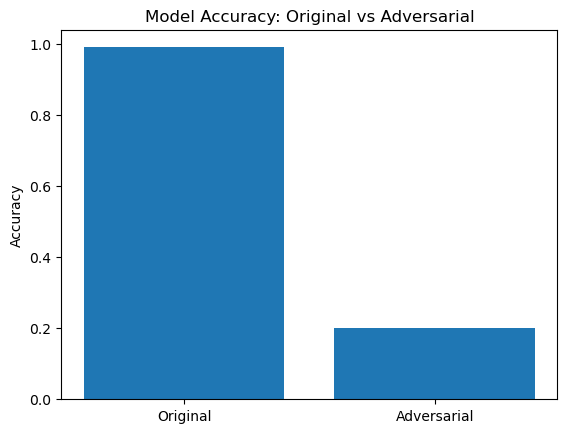

In [68]:
# Original test subset
loss, accuracy_before = model.evaluate(test_subset, test_labels_subset)
print("Original Model Accuracy: {:.2f}%".format(accuracy_before * 100))

# Adversarial test subset
loss, adversarial_accuracy_before = model.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarial Model Accuracy: {:.2f}%".format(adversarial_accuracy_before * 100))

# Plotting comparison
plt.bar(['Original', 'Adversarial'], [accuracy_before, adversarial_accuracy_before])
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Original vs Adversarial')
plt.show()


8. Visualize Some Original and Adversarial Images

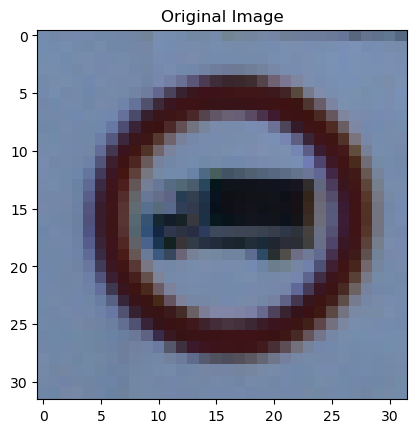

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


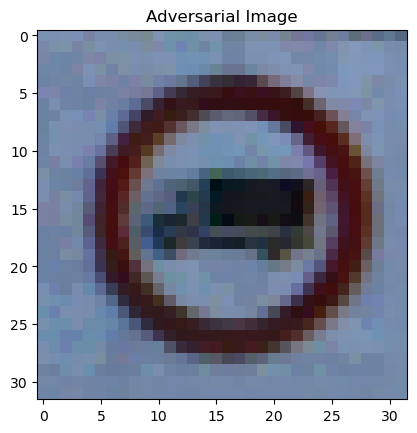

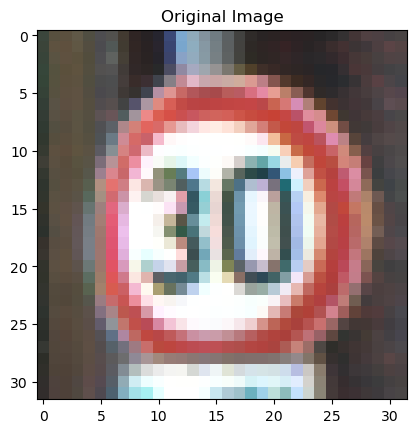

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


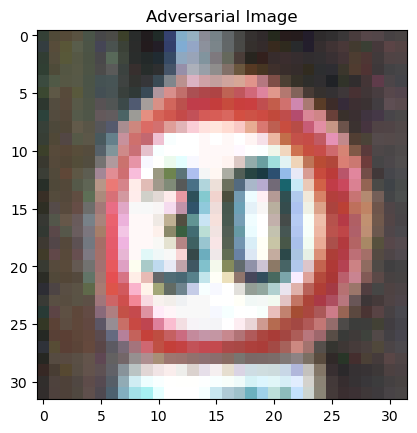

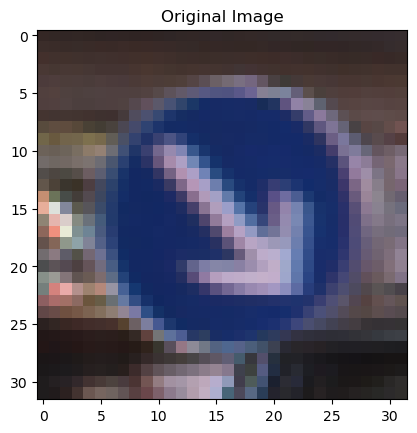

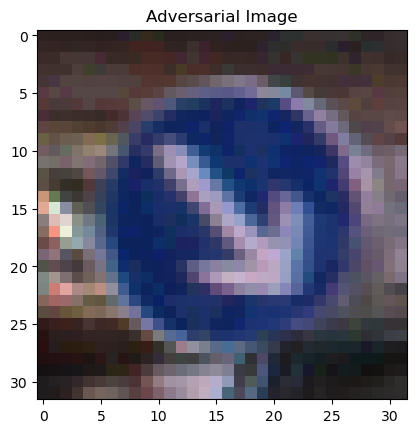

In [69]:
def display_images(image, description):
    plt.figure()
    plt.imshow(image[0])
    plt.title(description)
    plt.show()

for i in range(3):
    display_images(test_subset[i:i+1], "Original Image")
    display_images(adversarial_test_images[i:i+1], "Adversarial Image")


**DEFENSE**

1. Generate Adversarial Training Set

In [70]:
# Assuming train_subset and train_labels_subset are currently NumPy arrays
train_subset_tensor = tf.convert_to_tensor(train_subset, dtype=tf.float32)
train_labels_subset_tensor = tf.convert_to_tensor(train_labels_subset, dtype=tf.int64)

epsilon = 0.1
train_perturbations = create_adversarial_pattern(train_subset_tensor, train_labels_subset_tensor, model)
adversarial_train_images = train_subset_tensor + train_perturbations * epsilon

# Now, if you need to combine adversarial images with the original training set, ensure both are tensors or convert back to arrays


2. Retrain the Model with the Adversarial Training Set

Epoch 1/10
347/347 [==============================] - 3s 9ms/step - loss: 5.6586e-05 - accuracy: 1.0000 - val_loss: 0.0775 - val_accuracy: 0.9905
Epoch 2/10
347/347 [==============================] - 3s 9ms/step - loss: 4.6366e-05 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 0.9905
Epoch 3/10
347/347 [==============================] - 3s 9ms/step - loss: 3.8902e-05 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9905
Epoch 4/10
347/347 [==============================] - 3s 9ms/step - loss: 3.2726e-05 - accuracy: 1.0000 - val_loss: 0.0801 - val_accuracy: 0.9901
Epoch 5/10
347/347 [==============================] - 3s 9ms/step - loss: 2.8519e-05 - accuracy: 1.0000 - val_loss: 0.0807 - val_accuracy: 0.9901
Epoch 6/10
347/347 [==============================] - 3s 9ms/step - loss: 2.5032e-05 - accuracy: 1.0000 - val_loss: 0.0820 - val_accuracy: 0.9901
Epoch 7/10
347/347 [==============================] - 3s 8ms/step - loss: 2.0517e-05 - accuracy: 1.0000 - val_loss: 0.0839 -

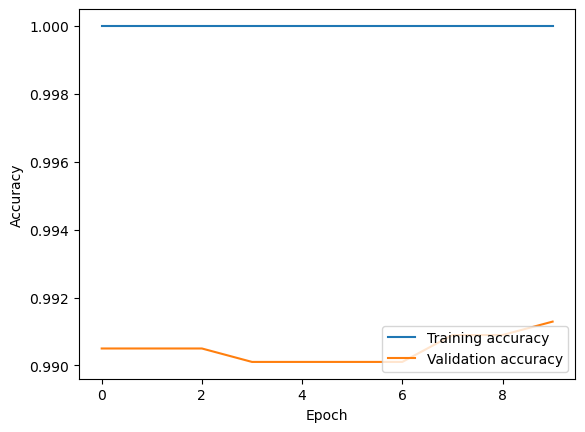

In [71]:
# Assuming you have your original training images and labels (train_images, train_labels)
# And your adversarial images and labels (adversarial_train_images, train_labels_subset)

# First, concatenate the images
combined_train_images = np.concatenate([train_images, adversarial_train_images])

# Then, concatenate the labels
# Note: If your adversarial examples use the same labels as the original examples,
# you can just duplicate the original labels.
combined_train_labels = np.concatenate([train_labels, train_labels_subset])

# Now you can use these combined datasets in your training
history_adversarial = model_adversarial_trained.fit(combined_train_images, combined_train_labels, epochs=10, validation_data=(val_images, val_labels))

# Continue with your plotting or other operations

plt.plot(history_adversarial.history['accuracy'], label='Training accuracy')
plt.plot(history_adversarial.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


3. Evaluate the Model Performance After Adversarial Training

4/4 [==============================] - 0s 3ms/step - loss: 6.6789e-04 - accuracy: 1.0000
Adversarially Trained Model Accuracy on Original Images: 100.00%
4/4 [==============================] - 0s 3ms/step - loss: 0.1299 - accuracy: 0.9800
Adversarially Trained Model Accuracy on Adversarial Images: 98.00%


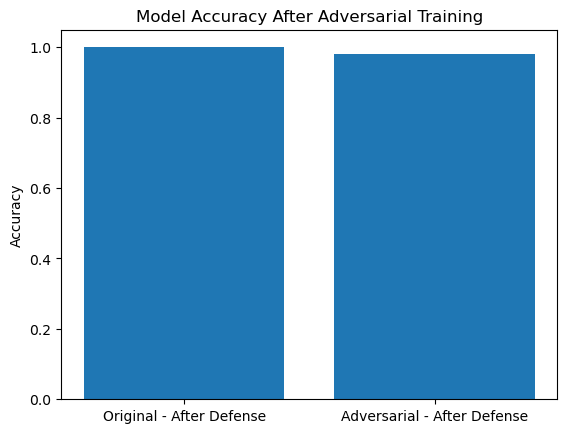

In [72]:
# Original test subset
loss, accuracy = model_adversarial_trained.evaluate(test_subset, test_labels_subset)
print("Adversarially Trained Model Accuracy on Original Images: {:.2f}%".format(accuracy * 100))

# Adversarial test subset
loss, adversarial_accuracy = model_adversarial_trained.evaluate(adversarial_test_images, test_labels_subset)
print("Adversarially Trained Model Accuracy on Adversarial Images: {:.2f}%".format(adversarial_accuracy * 100))

# Plotting comparison
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy])
plt.ylabel('Accuracy')
plt.title('Model Accuracy After Adversarial Training')
plt.show()


4. Visualize the Effectiveness of the Defense Strategy

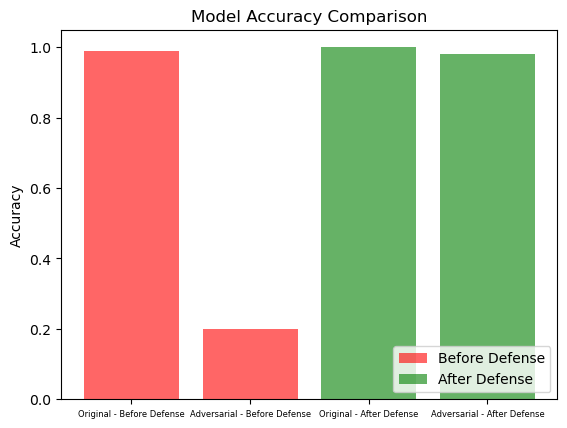

In [73]:
# Before Adversarial Training
plt.bar(['Original - Before Defense', 'Adversarial - Before Defense'], [accuracy_before, adversarial_accuracy_before], alpha=0.6, color='red')

# After Adversarial Training
plt.bar(['Original - After Defense', 'Adversarial - After Defense'], [accuracy, adversarial_accuracy], alpha=0.6, color='green')

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend(['Before Defense', 'After Defense'], loc='lower right')
plt.xticks(fontsize=6)
plt.show()
